In [1]:
# IF JUPYTER ISN'T COOPERATING, COMMENT THIS CODE BLOCK OUT
# Turn off autosaving of notebook. Use this to disable Jupyter notebook's default way of choosing Python executables
%autosave 0

# Import the sysconfig module
import sysconfig

# Loop over the items in the config_vars dictionary and print them out
for k,v in sysconfig.get_config_vars().items():
    # Use conditional expressions to determine how many tabs to print before the value
    # based on the length of the key name
    print(f"{k}", end=":")
    print("\t\t\t" if len(k)<7 else "\t\t" if len(k)<15 else "\t", end=f"{v}\n")


Autosave disabled
prefix:			/usr
exec_prefix:		/usr
py_version:		3.10.6
py_version_short:	3.10
py_version_nodot:	310
installed_base:		/usr
base:			/usr
installed_platbase:	/usr
platbase:		/usr
projectbase:		/usr/bin
platlibdir:		lib
abiflags:		
py_version_nodot_plat:	
ABIFLAGS:		
AC_APPLE_UNIVERSAL_BUILD:	0
AIX_BUILDDATE:		0
AIX_GENUINE_CPLUSPLUS:	0
ALIGNOF_LONG:		8
ALIGNOF_SIZE_T:		8
ALT_SOABI:		0
ANDROID_API_LEVEL:	0
AR:			x86_64-linux-gnu-gcc-ar
ARFLAGS:		rcs
BASECFLAGS:		-Wno-unused-result -Wsign-compare
BASECPPFLAGS:		-IObjects -IInclude -IPython
BASEMODLIBS:		
BINDIR:			/usr/bin
BINLIBDEST:		/usr/lib/x86_64-linux-gnu/python3.10
BLDLIBRARY:		-lpython3.10
BLDSHARED:		x86_64-linux-gnu-gcc -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions      -g -fwrapv -O2   
BUILDEXE:		
BUILDPYTHON:		python
BUILD_GNU_TYPE:		x86_64-pc-linux-gnu
BYTESTR_DEPS:		\
CC:			x86_64-linux-gnu-gcc
CCSHARED:		-fPIC
CFLAGS:			-Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g   

In [2]:
from datetime import datetime
from sim.pool import AMMPoolHistory, CPMM, AMMWithBaulking, OraclePool, RebalancingPool
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Data Analysis of Prices

### Polars Preprocessing

In [3]:
# load parquet file into polars dataframe polars dataframe
cow_uni_chain_outer_pl = pl.read_parquet('data/cow_uni_chain_outer_pl_historical.parquet')

In [4]:
# NOTE CAREFUL! This command was done in data_pipeline_final but appears to have reverted. Apply decimal conversion to chainlink again
cow_uni_chain_outer_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("prices_price")/ 10 ** 8).alias('prices_price')
])

In [5]:
cow_uni_chain_outer_pl.shape

(166280, 23)

In [6]:
cow_uni_chain_outer_pl.select([
    (pl.col("swaps_tokenOut_id")).value_counts(),
    (pl.col("trades_buyToken_id")).value_counts(),
]).rows()

[({'swaps_tokenOut_id': 'WETH', 'counts': 15821},
  {'trades_buyToken_id': 'USDC', 'counts': 28961}),
 ({'swaps_tokenOut_id': None, 'counts': 129544},
  {'trades_buyToken_id': None, 'counts': 124603}),
 ({'swaps_tokenOut_id': 'USDC', 'counts': 20915},
  {'trades_buyToken_id': 'WETH', 'counts': 12716})]

In [7]:
# return the larger value between trades_buy_sell_ratio and trades_sell_buy_ratio in a lambda function. This serves as a column equalization function for trades_buy_sell_ratio and trades_sell_buy_ratio
execution_prices_pl = cow_uni_chain_outer_pl.with_columns([
    (pl.col("trades_buy_sell_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_buy_sell_ratio'),
    (pl.col("trades_sell_buy_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('trades_sell_buy_ratio'),
    (pl.col("swaps_amountIn_amountOut_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountIn_amountOut_ratio'),
    (pl.col("swaps_amountOut_amountIn_ratio").apply(lambda x: x if x > 1 else 1/x)).alias('swaps_amountOut_amountIn_ratio'),
])

In [8]:
# Add trade directionality flag.
# we label the trade direction WETH -> USDC when WETH is in the CoW buy column and the UniV3 amountOut column. 
# Conversely, the USDC -> WETH direction is when USDC is in the CoW sell column and the Univ3 amountIn column.
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buyToken_id").apply(lambda x: True if x == 'WETH' else False)).alias('trades_buy_WETH'),
    (pl.col("swaps_tokenOut_id").apply(lambda x: True if x == 'WETH' else False)).alias('swaps_buy_WETH'),
])

In [9]:
# match cow trades with univ3 swaps
execution_prices_pl = execution_prices_pl.with_columns([
    (pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('buy_buy_WETH'), # cow buy/uni buy WETH
    (~pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('sell_sell_WETH'), # cow sell/uni sell WETH
    (pl.col("trades_buy_WETH") & ~pl.col("swaps_buy_WETH")).alias('buy_sell_WETH'), # cow buy/uni sel WETH
    (~pl.col("trades_buy_WETH") & pl.col("swaps_buy_WETH")).alias('sell_buy_WETH'), # cow sell/uni buy WETH
])

### Pandas Preprocessing

In [10]:
# convert execution_prices_pl to pandas dataframe for easier plotting.
execution_prices_pd = execution_prices_pl.to_pandas()

# set trades_timestamp as index and order by trades_timestamp
execution_prices_pd = execution_prices_pd.set_index('trades_timestamp').sort_index()

# create a new dataframe with a unique integer index. make the current timestamp index a column
reindexed_df = execution_prices_pd.reset_index()

In [11]:
# select columns to keep
reindexed_price_df = reindexed_df[[
    'trades_timestamp',                     # timestamp
    'trades_sell_buy_ratio',                # cow price
    'swaps_amountOut_amountIn_ratio',       # univ3 price
    'prices_price',                         # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_buy_WETH',                         # cow/uni buy direction
    'sell_sell_WETH',                       # cow/uni sell direction
    'buy_sell_WETH',                        # cow buy/uni sell direction
    'sell_buy_WETH'                         # cow sell/uni buy direction
    ]]

# rename columns
reindexed_price_df.columns = [
    'timestamp',                            # timestamp
    'cow_price',                            # cow price
    'univ3_price',                          # univ3 price
    'chain_price',                          # chain price
    'transaction_gas_fee_one_hop',          # univ3 single hop swap
    'transaction_gas_fee_median',           # univ3 median swap transaction cost
    'buy_buy_WETH',                         # trade direction
    'sell_sell_WETH',                       # trade direction
    'buy_sell_WETH',                        # trade direction
    'sell_buy_WETH'                         # trade direction
]

In [12]:
# forward fill reindexed_price_df
reindexed_price_df = reindexed_price_df.fillna(method='ffill')

In [13]:
reindexed_price_df.shape

(166280, 10)

In [14]:
# convert transaction_gas_fee into usd amount
reindexed_price_df['transaction_gas_fee_one_hop_usd'] = reindexed_price_df['transaction_gas_fee_one_hop'] * reindexed_price_df['univ3_price']
reindexed_price_df['transaction_gas_fee_median_usd'] = reindexed_price_df['transaction_gas_fee_median'] * reindexed_price_df['univ3_price']

In [15]:
# filter trade directions. There are 4 total cases:
# cow buy/uni buy WETH
# cow sell/uni sell WETH
# cow buy/uni sell WETH
# cow sell/uni buy WETH
buy_buy_WETH_reindex_df = reindexed_price_df[reindexed_price_df['buy_buy_WETH'] == True]
sell_sell_WETH_reindex_df = reindexed_price_df[reindexed_price_df['sell_sell_WETH'] == True]
buy_sell_WETH_reindex_df = reindexed_price_df[reindexed_price_df['buy_sell_WETH'] == True]
sell_buy_WETH_reindex_df = reindexed_price_df[reindexed_price_df['sell_buy_WETH'] == True]

In [16]:
# print f the df shapes. Note that the dataframes have grown in size due to the forward fill method above.
print(buy_buy_WETH_reindex_df.shape)
print(sell_sell_WETH_reindex_df.shape)
print(buy_sell_WETH_reindex_df.shape)
print(sell_buy_WETH_reindex_df.shape)

(12479, 12)
(32297, 12)
(7986, 12)
(17226, 12)


In [17]:
# get all values below the 90th percentile
buy_buy_WETH_df = buy_buy_WETH_reindex_df[buy_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < buy_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
sell_sell_WETH_df = sell_sell_WETH_reindex_df[sell_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < sell_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
buy_sell_WETH_df = buy_sell_WETH_reindex_df[buy_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < buy_sell_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]
sell_buy_WETH_df = sell_buy_WETH_reindex_df[sell_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'] < sell_buy_WETH_reindex_df['transaction_gas_fee_one_hop_usd'].quantile(0.90)]

In [18]:
print(f'cow and uni buy count: {buy_buy_WETH_df.shape}')
print(f'cow and uni sell count: {sell_sell_WETH_df.shape}')
print(f'cow buy and uni sell count: {buy_sell_WETH_df.shape}')
print(f'uni sell and cow buy count: {sell_buy_WETH_df.shape}')

cow and uni buy count: (11231, 12)
cow and uni sell count: (29067, 12)
cow buy and uni sell count: (7186, 12)
uni sell and cow buy count: (15502, 12)


In [19]:
# single hop gas adjusted prices
buy_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
buy_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_sell_WETH_df.loc[:, 'univ3_price'] - buy_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
sell_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_buy_WETH_df.loc[:, 'univ3_price'] + sell_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']

# add new price values that add the gas cost
buy_buy_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_sell_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
buy_sell_WETH_df.loc[:, 'univ3_gas_median_price'] = buy_sell_WETH_df.loc[:, 'univ3_price'] - buy_sell_WETH_df.loc[:, 'transaction_gas_fee_median_usd']
sell_buy_WETH_df.loc[:, 'univ3_gas_median_price'] = sell_buy_WETH_df.loc[:, 'univ3_price'] + sell_buy_WETH_df.loc[:, 'transaction_gas_fee_median_usd']

/tmp/ipykernel_74162/807861930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = buy_buy_WETH_df.loc[:, 'univ3_price'] + buy_buy_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_74162/807861930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df.loc[:, 'univ3_gas_single_hop_price'] = sell_sell_WETH_df.loc[:, 'univ3_price'] - sell_sell_WETH_df.loc[:, 'transaction_gas_fee_one_hop_usd']
/tmp/ipykernel_74162/807861930.py:

In [20]:
# convert index to datetime format
sell_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_sell_WETH_df.timestamp, utc=True, unit='s')
buy_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_buy_WETH_df.timestamp, utc=True, unit='s')
buy_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_sell_WETH_df.timestamp, utc=True, unit='s')
sell_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_buy_WETH_df.timestamp, utc=True, unit='s')

/tmp/ipykernel_74162/530421318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(sell_sell_WETH_df.timestamp, utc=True, unit='s')
/tmp/ipykernel_74162/530421318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df.loc[:, 'timestamp'] = pd.to_datetime(buy_buy_WETH_df.timestamp, utc=True, unit='s')
/tmp/ipykernel_74162/530421318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

### Price Charts

In [21]:
# define color scheme
cow_color = '#0000b3'
univ3_color = '#993366'
chain_color = '#004d00'

In [22]:
# what is the date at the -2000th row for sell_sell_WETH_df?
print(sell_sell_WETH_df.iloc[-2000].timestamp)

graph_chart_date = sell_sell_WETH_df.iloc[-2000].timestamp

2023-01-17 00:55:35+00:00


In [23]:
# first date in the dataframe
print(sell_sell_WETH_df.iloc[0].timestamp)

graph_chart_date = sell_sell_WETH_df.iloc[0].timestamp

2021-08-06 13:27:54+00:00


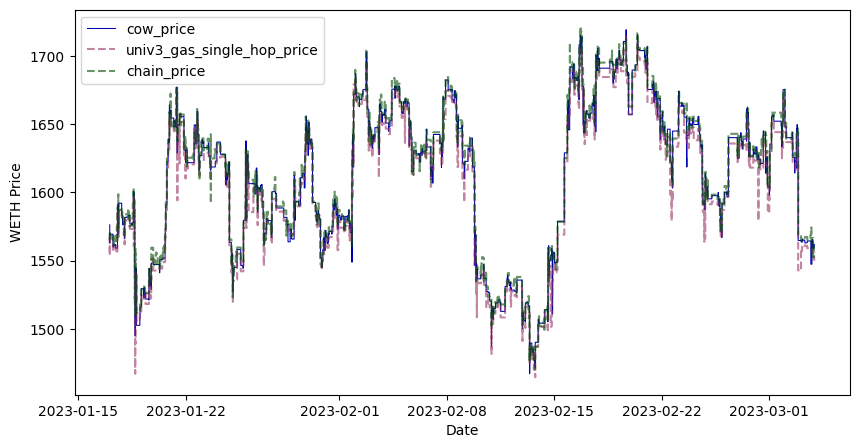

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [24]:
# plot prices on y axis and timestamp on x axis
fig1, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['cow_price'].iloc[-2000:], 
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['univ3_gas_single_hop_price'].iloc[-2000:], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    sell_sell_WETH_df['timestamp'].iloc[-2000:], 
    sell_sell_WETH_df['chain_price'].iloc[-2000:], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

# save figure
fig1.savefig('../report/diagrams/weth_sell_line.eps', format='eps', bbox_inches='tight')
fig1.savefig('../report/diagrams/weth_sell_line.pdf', format='pdf', bbox_inches='tight')

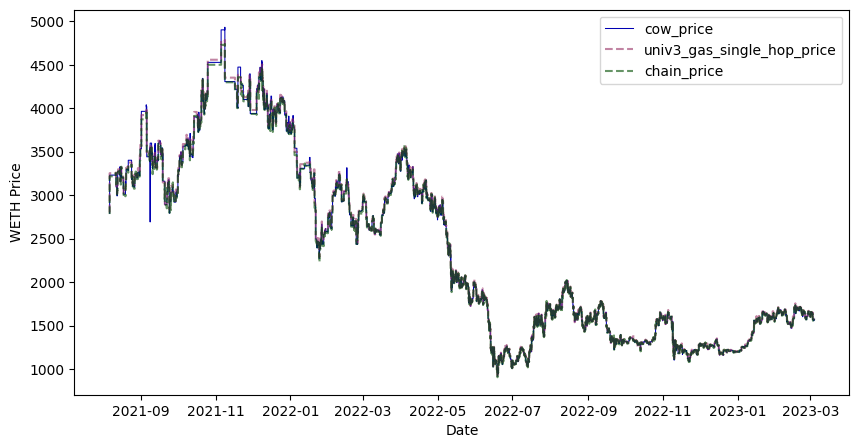

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [25]:
# plot buy_buy_WETH_df chart where the timestamp is after the graph_chart_date variable
fig2, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_buy_WETH_df[buy_buy_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.show();

fig2.savefig('../report/diagrams/weth_buy_line.eps', format='eps', bbox_inches='tight')
fig2.savefig('../report/diagrams/weth_buy_line.pdf', format='pdf', bbox_inches='tight')

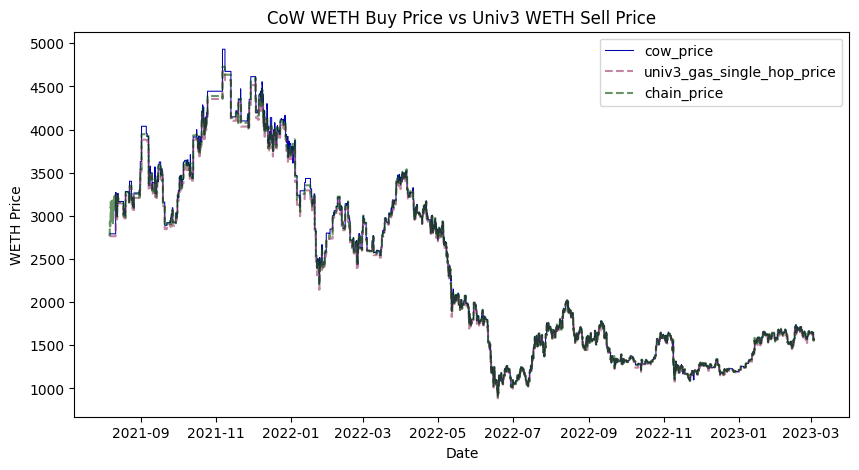

In [26]:
# plot prices on y axis and timestamp on x axis
fig3, ax = plt.subplots(figsize=(10, 5))
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    buy_sell_WETH_df[buy_sell_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.title('CoW WETH Buy Price vs Univ3 WETH Sell Price')
plt.show();

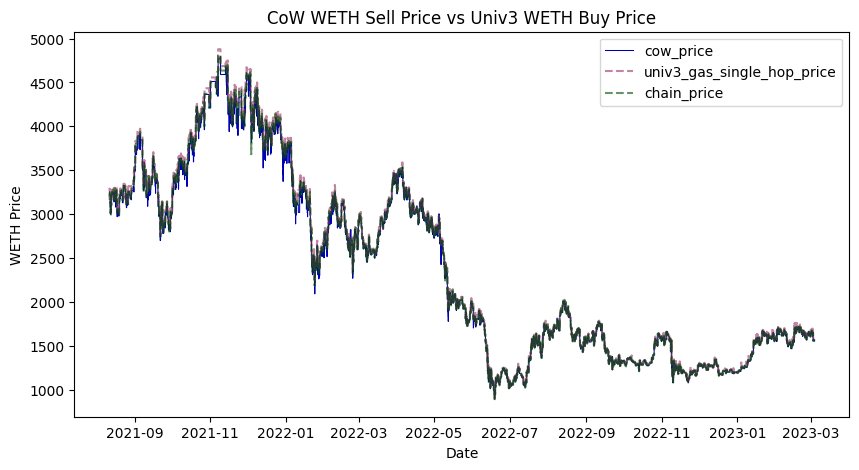

In [27]:
# plot prices on y axis and timestamp on x axis
fig4, ax = plt.subplots(figsize=(10, 5))
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['cow_price'],
    label='cow_price',color=cow_color, linewidth=.75)
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['univ3_gas_single_hop_price'], '--',
    label='univ3_gas_single_hop_price', color=univ3_color, alpha=.6)
ax.step(
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['timestamp'],
    sell_buy_WETH_df[sell_buy_WETH_df['timestamp'] > graph_chart_date]['chain_price'], '--',
    label='chain_price', color=chain_color, alpha=.6)

plt.xlabel('Date')
plt.ylabel('WETH Price')
plt.legend()
plt.title('CoW WETH Sell Price vs Univ3 WETH Buy Price')
plt.show();

### Price Differences Charts

In [28]:
# get the price price difference percent between cow and univ3 gas adjusted price in buy_buy_WETH_df
buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_single_hop_price']) / buy_buy_WETH_df['cow_price'] * 100
buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_median_price']) / buy_buy_WETH_df['cow_price'] * 100

/tmp/ipykernel_74162/2877689058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_single_hop_price']) / buy_buy_WETH_df['cow_price'] * 100
/tmp/ipykernel_74162/2877689058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (buy_buy_WETH_df['cow_price'] - buy_buy_WETH_df['univ3_gas_median_price']) / buy_buy_WETH_df['cow_

In [29]:
# get the price price difference percent between cow and univ3 gas adjusted price in sell_sell_WETH_df
sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_single_hop_price']) / sell_sell_WETH_df['cow_price'] * 100
sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_median_price']) / sell_sell_WETH_df['cow_price'] * 100

/tmp/ipykernel_74162/269593933.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_single_hop_price']) / sell_sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_74162/269593933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_median'] = (sell_sell_WETH_df['cow_price'] - sell_sell_WETH_df['univ3_gas_median_price']) / sell_sell

In [30]:
# calculate mean deviation between cow and chain prices for each row
sell_sell_WETH_df['cow_chain_price_diff_percent'] = (sell_sell_WETH_df['chain_price'] - sell_sell_WETH_df['cow_price']) / sell_sell_WETH_df['cow_price'] * 100
buy_buy_WETH_df['cow_chain_price_diff_percent'] = (buy_buy_WETH_df['chain_price'] - buy_buy_WETH_df['cow_price']) / buy_buy_WETH_df['cow_price'] * 100

/tmp/ipykernel_74162/3633560276.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sell_sell_WETH_df['cow_chain_price_diff_percent'] = (sell_sell_WETH_df['chain_price'] - sell_sell_WETH_df['cow_price']) / sell_sell_WETH_df['cow_price'] * 100
/tmp/ipykernel_74162/3633560276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_buy_WETH_df['cow_chain_price_diff_percent'] = (buy_buy_WETH_df['chain_price'] - buy_buy_WETH_df['cow_price']) / buy_buy_WETH_df['cow_price'] * 100


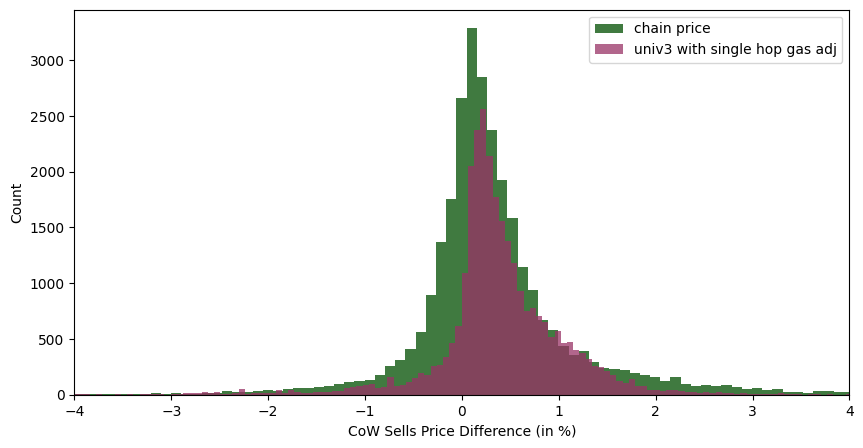

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [31]:
# plot histogram of the price diffs
# https://matplotlib.org/stable/gallery/misc/rasterization_demo.html
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    sell_sell_WETH_df['cow_chain_price_diff_percent'],
    bins=250,
    label='chain price',
    color=chain_color,
    alpha=0.75)
ax.hist(
    sell_sell_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=250,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('CoW Sells Price Difference (in %)')
plt.ylabel('Count')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_sell_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_sell_hist.pdf', format='pdf', bbox_inches='tight')

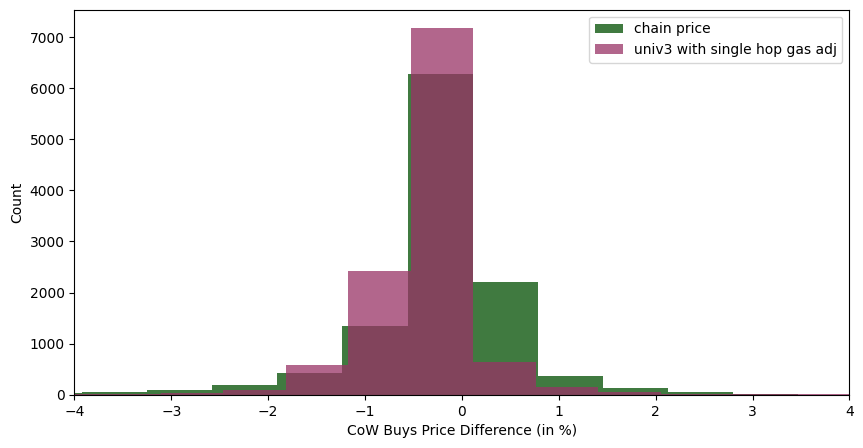

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [32]:
# plot histogram of the price diffs
fig3, ax = plt.subplots(figsize=(10, 5))
ax.hist(
    buy_buy_WETH_df['cow_chain_price_diff_percent'],
    bins=50,
    label='chain price',
    color=chain_color,
    alpha=0.75)
ax.hist(
    buy_buy_WETH_df['cow_univ3_gas_adj_price_diff_percent_single'],
    bins=50,
    label='univ3 with single hop gas adj',
    color=univ3_color,
    alpha=0.75)

ax.set_xlim(-4, 4)
plt.xlabel('CoW Buys Price Difference (in %)')
plt.ylabel('Count')
plt.legend()
plt.show();

#save as eps
fig3.savefig('../report/diagrams/weth_buy_hist.eps', format='eps', bbox_inches='tight')
fig3.savefig('../report/diagrams/weth_buy_hist.pdf', format='pdf', bbox_inches='tight')

In [33]:
# print the mean deviation of cow price from chainlink price with f strings
print(f"Mean deviation of cow sell price from chainlink price (90th percentile): {sell_sell_WETH_df['cow_chain_price_diff_percent'].mean():.2f}%")
print(f"Mean deviation of cow buy price from chainlink price (90th percentile): {buy_buy_WETH_df['cow_chain_price_diff_percent'].mean():.2f}%")

Mean deviation of cow sell price from chainlink price (90th percentile): 0.35%
Mean deviation of cow buy price from chainlink price (90th percentile): -0.22%


In [34]:
# statistics for buy_WETH_df single hop price difference
buy_buy_WETH_df[['transaction_gas_fee_one_hop_usd', 'cow_univ3_gas_adj_price_diff_percent_median', 'cow_univ3_gas_adj_price_diff_percent_single', 'cow_chain_price_diff_percent']].describe()

,transaction_gas_fee_one_hop_usd,cow_univ3_gas_adj_price_diff_percent_median,cow_univ3_gas_adj_price_diff_percent_single,cow_chain_price_diff_percent
count,11231.000000,11231.000000,11231.000000,11231.000000
mean,12.490326,-1.237658,-0.361638,-0.222255
std,12.733570,1.210310,0.683515,0.883017
min,0.546391,-29.894727,-27.639289,-6.602695
25%,3.030933,-1.663110,-0.579787,-0.442973
50%,6.600336,-0.900348,-0.289985,-0.137440
75%,18.778199,-0.475578,-0.117467,0.106586
max,50.809669,3.410353,4.636215,26.959837


In [35]:
sell_sell_WETH_df[['transaction_gas_fee_one_hop_usd', 'cow_univ3_gas_adj_price_diff_percent_median', 'cow_univ3_gas_adj_price_diff_percent_single', 'cow_chain_price_diff_percent']].describe()

,transaction_gas_fee_one_hop_usd,cow_univ3_gas_adj_price_diff_percent_median,cow_univ3_gas_adj_price_diff_percent_single,cow_chain_price_diff_percent
count,29067.000000,29067.000000,29067.000000,29067.000000
mean,17.019268,1.441330,0.379003,0.351112
std,16.277558,1.314485,0.753879,1.056214
min,0.410962,-7.256415,-9.400605,-13.629874
25%,3.789228,0.542242,0.125590,-0.039729
50%,10.044869,1.090466,0.324848,0.213235
75%,27.130775,2.061434,0.690312,0.596120
max,60.772280,13.710024,6.582242,12.674928


### Simulations

#### Preprocessing

In [36]:
# divide the merged dataframe into smaller dataframes. We used an outerjoin in the data pipeline notebook which introduces null values. Now we drop the null values to recover the pre-outer join dataframes. 
# Recall the preprocessing step to forwardfill values. This makes the recovered dataframes larger in size.
uni_swaps_df = cow_uni_chain_outer_pl[
    'trades_timestamp',  
    'swaps_tokenIn_id',
    'swaps_tokenOut_id',
    'swaps_amountIn_converted',
    'swaps_amountOut_converted'
    ].drop_nulls()

chain_df = cow_uni_chain_outer_pl[    
    'trades_timestamp', 
    'prices_assetPair_id', 
    'prices_price'].drop_nulls()


cow_df = cow_uni_chain_outer_pl[
    'trades_timestamp',
    'swaps_blockNumber',
    'trades_txHash',
    'trades_feeAmount',
    'trades_sellToken_id',
    'trades_buyToken_id',
    'trades_sellAmount_converted',
    'trades_buyAmount_converted',
    'name',
    'environment'
].drop_nulls()

In [37]:
# print size
print(f"Size of uni_swaps_df: {uni_swaps_df.shape}")
print(f"Size of chain_df: {chain_df.shape}")
print(f"Size of cow_df: {cow_df.shape}")

Size of uni_swaps_df: (36736, 5)
Size of chain_df: (125450, 3)
Size of cow_df: (36736, 10)


In [38]:
# convert to pandas dataframes
uni_swaps_df = uni_swaps_df.to_pandas()
chain_df = chain_df.to_pandas()
cow_df = cow_df.to_pandas()

In [39]:
# sort all by trades timestamp
uni_swaps_df = uni_swaps_df.sort_values(by=['trades_timestamp'])
chain_df = chain_df.sort_values(by=['trades_timestamp'])
cow_df = cow_df.sort_values(by=['trades_timestamp'])

In [40]:
# filter based on timestamp
uni_swaps_df = uni_swaps_df[uni_swaps_df['trades_timestamp'] >= 1643673600]
chain_df = chain_df[chain_df['trades_timestamp'] >= 1643673600]
cow_df = cow_df[cow_df['trades_timestamp'] >= 1643673600]

In [41]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['trades_timestamp'].min()
last_timestamp_uni = uni_swaps_df['trades_timestamp'].max()
print(f'uni first timestamp: {first_timestamp_uni} \nlast timestamp: {last_timestamp_uni}')

# Find the first and last value in the timestamp column
first_timestamp_chain = chain_df['trades_timestamp'].min()
last_timestamp_chain = chain_df['trades_timestamp'].max()
print(f'chain first timestamp: {first_timestamp_chain} \nlast timestamp: {last_timestamp_chain}')

uni first timestamp: 1643677681 
last timestamp: 1677890687
chain first timestamp: 1643676926 
last timestamp: 1677891335


In [42]:
timestamps = pd.DataFrame({'trades_timestamp': range(first_timestamp_uni, last_timestamp_uni + 1)})

In [43]:
print(len(timestamps))

34213007


#### Create Chainlink Oracle

In [44]:
# left merge chain_df with empty timestamps_df
chain_filled_df = pd.merge(timestamps, chain_df, on='trades_timestamp', how='left')
# Forward-fill missing values
chain_filled_df.fillna(method='ffill', inplace=True)
# sort by timestamp
chain_filled_df = chain_filled_df.sort_values('trades_timestamp', ascending=True)

In [45]:
# get first non null price row
first_non_null_price_row = chain_filled_df[chain_filled_df['prices_price'].notnull()].iloc[0]

In [46]:
# get simulation initialization data from the first row of the chain data
initialization_df_row = chain_filled_df[chain_filled_df["trades_timestamp"] == first_non_null_price_row['trades_timestamp']]
initilization_price = initialization_df_row['prices_price']

# initialize 100m USDC supply reserve amount
USDC_reserves_USD = 100000000

token0_start = int(USDC_reserves_USD/initilization_price)
print(f"Token 0 WETH initial reserves: \t{token0_start}")

token1_start = USDC_reserves_USD
print(f"Token 1 USDC initial reserves :\t{token1_start}")

# convert initialization_df['trades_timestamp'][0] to datetime object
datetime_object = datetime.fromtimestamp(initialization_df_row['trades_timestamp'].iloc[0]).strftime('%Y-%m-%d')

print(f'start date: {datetime_object}, start WETH price: {initilization_price.iloc[0]}')

Token 0 WETH initial reserves: 	37225
Token 1 USDC initial reserves :	100000000
start date: 2022-01-31, start WETH price: 2686.34606792


In [47]:
# convert into series. This data structure is required for the simulation class input
price_s = chain_filled_df.set_index("trades_timestamp")["prices_price"]

# drop null values
price_s = price_s[price_s.index > first_non_null_price_row['trades_timestamp']]

In [48]:
# merge duplicated index values in price_s. This is the 'external market oracle' for the CPMM
price_s = price_s.groupby(level=0).first()

#### Create CoW Oracle

In [49]:
# drop NaN values in cow_price column from the earlier completed dataset.
cow_oracle_df = reindexed_price_df[reindexed_price_df['cow_price'].notnull()]

In [50]:
# create an oracle dict which serves as a price oracle for OraclePool
oracle_dict = [{"ts": row["timestamp"], "p": row["cow_price"]} for _, row in cow_oracle_df.iterrows()]

#### Oracle Price Chart

In [51]:
# convert oracle_dict to a df
oracle_df = pd.DataFrame(oracle_dict)

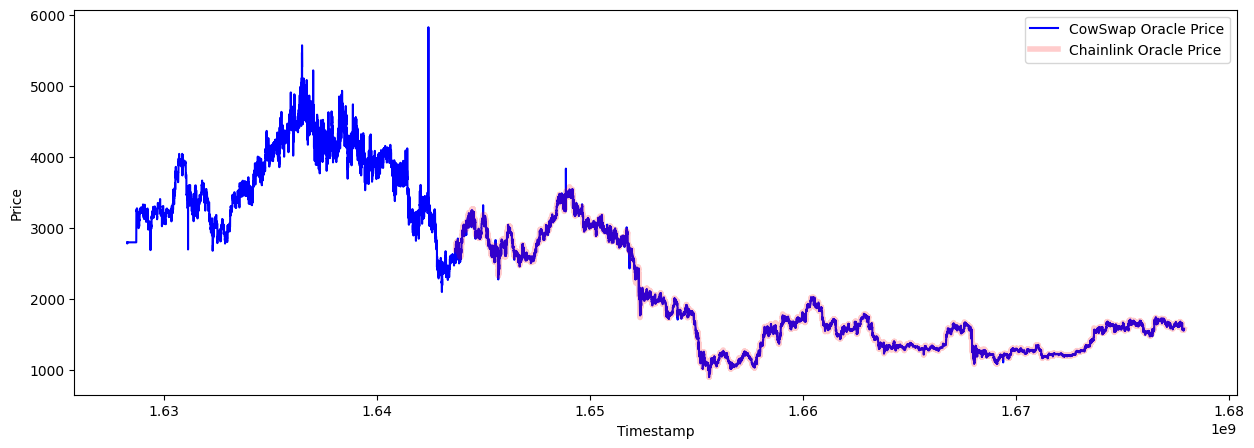

In [52]:
# plot oracle_df and price_s on same plot. UNOPTIMIZED chart rendering! Takes a few seconds.
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(oracle_df['ts'], oracle_df['p'], label='CowSwap Oracle Price', color='blue')
ax.plot(price_s.index, price_s, label='Chainlink Oracle Price', color='red', alpha=0.2, linewidth=4)
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price')
ax.legend()
plt.show()

#### Simulation Execution & Preprocessing

In [53]:
# Create feedlot history objects, which store the data of the simulation.
feedlot1 = AMMPoolHistory(token0_start, token1_start)
feedlot2 = AMMPoolHistory(token0_start, token1_start)
feedlot3 = AMMPoolHistory(token0_start/2, token1_start/2)

In [54]:
cow_oracle = cow_oracle_df[["timestamp","cow_price"]]
cow_oracle.columns = ["ts", "p"]

In [55]:
# Instantiate the CPMM object with the AMMPool object
cpmm = CPMM(pool=feedlot1)
cpmm_SI_flow = AMMWithBaulking(cpmm, price_s)
oracle_pool = OraclePool(feedlot2, (v for _,v in cow_oracle.iterrows()))
rebalancing_pool = RebalancingPool(feedlot3, (v for _,v in cow_oracle.iterrows()))

In [56]:
# Initialize a counter for trades that deplete the reserves
depleted_reserve_count = 0
# Initialize empty list to store a list of transactions that trigger when reserves are depleted.
depleted_reserve_df = []

# Iterate through each row in the uni_swaps_df dataframe
for index, row in uni_swaps_df.iterrows():
    # Check if the trade occurred after the external market price oracle data was last updated
    if row['trades_timestamp'] > cpmm_SI_flow.target_prices.index[0]:
        # Determine which token is being traded (WETH or USDC) and how much is being traded
        # using a switch statement (supported in Python 3.10+)
        match row['swaps_tokenIn_id']:
            case 'WETH':
                token = 0
                amt = row['swaps_amountIn_converted']
            case 'USDC':
                token = 1
                amt = row['swaps_amountIn_converted']

        # If the reserve is depleted, nullify the trade by setting the amount in and out to 0.
        # Otherwise, execute the swap function on the AMM pool and the market order sell function
        # on the oracle pool
        amta, amtb = cpmm_SI_flow.maybe_market_order_sell(amt, token, row['trades_timestamp'])
        amt0, amt1 = oracle_pool.market_order_sell(amt, token, row['trades_timestamp'])

        # Count transactions that deplete the reserves and store them in a separate dataframe
        if amt0 == 0:
            # print(f"Reserves depleted at time {row['trades_timestamp']}.")
            # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")
            depleted_reserve_count += 1
            depleted_reserve_df.append(row)
        # print(f"Traded {amt0} for {amt1}\tat time {row['trades_timestamp']}.")
        # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")


In [57]:
print(f'depleted_reserve_count: {depleted_reserve_count}, total swaps going through sim: {uni_swaps_df.shape}')

depleted_reserve_count: 818, total swaps going through sim: (27762, 5)


In [58]:
def preprocess_history(pool: AMMPoolHistory) -> pd.DataFrame:
    """
    Use this function to prepare the simulation data for plotting. Computes values in USD
    """
    df = pd.merge(pd.DataFrame(pool.history[1:]), chain_df, left_on='ts', right_on='trades_timestamp', how='inner')
    df["reserve0_usd"] = df["reserve0"] * df["prices_price"]
    df["tvl"] = df["reserve0_usd"] + df["reserve1"]
    df = df.set_index(pd.to_datetime(df['ts'], unit='s'), drop=True)
    return df[~df.index.duplicated(keep="last")]

In [59]:
cpmm_amm_baulking_df = preprocess_history(feedlot1)
oracle_pool_df = preprocess_history(feedlot2)
rebalancing_pool_df = preprocess_history(feedlot3)

In [60]:
# count the number of swaps in results1 and results 2
print(f"Number of swaps in the order flow historical data: {uni_swaps_df.shape}")
print(f"Number of swaps accepted in CPMM: {cpmm_amm_baulking_df.shape}")
print(f"Number of swaps accepted in OraclePool: {oracle_pool_df.shape}")
print(f"Number of rebalances: {rebalancing_pool_df.shape}")

Number of swaps in the order flow historical data: (27762, 5)
Number of swaps accepted in CPMM: (173, 8)
Number of swaps accepted in OraclePool: (173, 8)
Number of rebalances: (23817, 8)


In [61]:
oracle_pool_df

,ts,reserve0,reserve1,trades_timestamp,prices_assetPair_id,prices_price,reserve0_usd,tvl
ts,,,,,,,,
2022-02-02 14:47:39,1643813259,36927.465211,1.008157e+08,1643813259,ETH/USD,2719.706885,1.004319e+08,2.012476e+08
2022-02-02 22:27:31,1643840851,38102.929598,9.777581e+07,1643840851,ETH/USD,2675.067210,1.019279e+08,1.997037e+08
2022-02-04 17:57:39,1643997459,37918.784443,9.829024e+07,1643997459,ETH/USD,2954.686399,1.120381e+08,2.103284e+08
2022-02-07 05:55:08,1644213308,37144.979006,1.006193e+08,1644213308,ETH/USD,3095.863066,1.149958e+08,2.156150e+08
2022-02-11 20:16:01,1644610561,36824.845468,1.017773e+08,1644610561,ETH/USD,2951.835957,1.087009e+08,2.104782e+08
...,...,...,...,...,...,...,...,...
2023-02-19 20:07:23,1676837243,79628.753457,4.619645e+06,1676837243,ETH/USD,1675.300000,1.334021e+08,1.380217e+08
2023-02-20 01:15:35,1676855735,79514.753457,4.814043e+06,1676855735,ETH/USD,1654.173105,1.315312e+08,1.363452e+08
2023-02-22 02:07:11,1677031631,80641.378560,2.925990e+06,1677031631,ETH/USD,1632.130510,1.316173e+08,1.345432e+08


In [62]:
# Due to a possible pandas bug, it appears rebalancing pool tvl is doubled. Divide the reserve values by 2 to get the correct tvl.
# rebalancing_pool_df['tvl'] = rebalancing_pool_df['tvl'] / 2

#### Simulation Charts

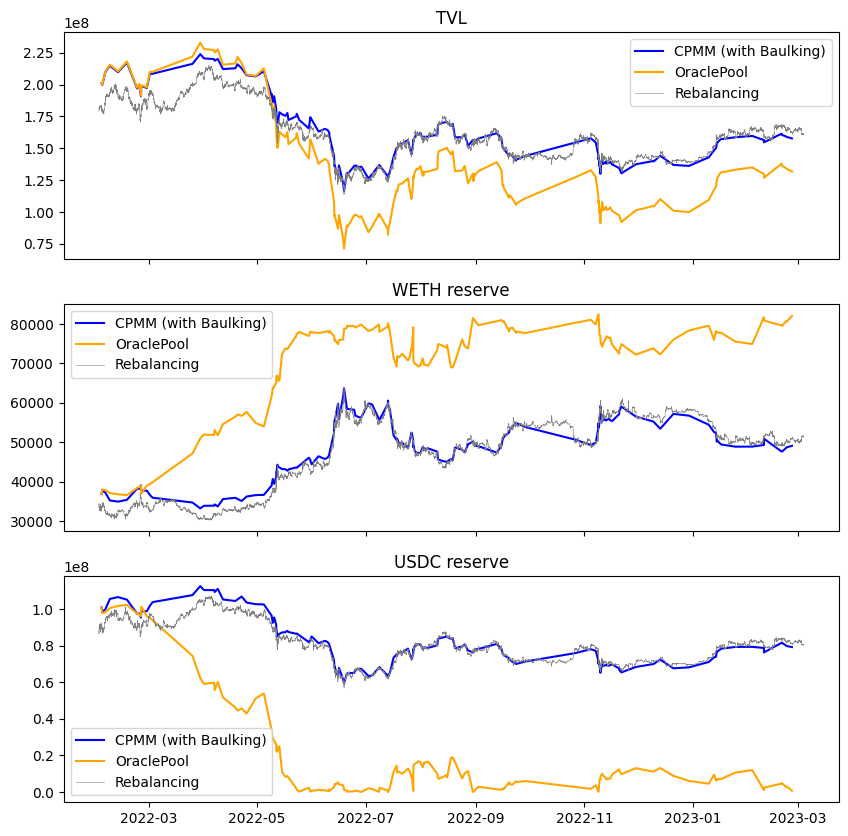

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [63]:
# plot subplots of merged dfs tvl
fig4, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax0.plot(cpmm_amm_baulking_df.index, cpmm_amm_baulking_df['tvl'], color='blue', label='CPMM (with Baulking)')
ax0.plot(oracle_pool_df.index, oracle_pool_df['tvl'], color='orange', label='OraclePool')
ax0.plot(rebalancing_pool_df.index, rebalancing_pool_df['tvl'], color='grey', label='Rebalancing', linewidth=0.4)
ax0.set_title('TVL')
ax0.legend()
ax1.plot(cpmm_amm_baulking_df.index, cpmm_amm_baulking_df['reserve0'], color='blue', label='CPMM (with Baulking)')
ax1.plot(oracle_pool_df.index, oracle_pool_df['reserve0'], color='orange', label='OraclePool')
ax1.plot(rebalancing_pool_df.index, rebalancing_pool_df['reserve0'], color='grey', label='Rebalancing', linewidth=0.4)
ax1.set_title('WETH reserve')
ax1.legend()
ax2.plot(cpmm_amm_baulking_df.index, cpmm_amm_baulking_df['reserve1'], color='blue', label='CPMM (with Baulking)')
ax2.plot(oracle_pool_df.index, oracle_pool_df['reserve1'], color='orange', label='OraclePool')
ax2.plot(rebalancing_pool_df.index, rebalancing_pool_df['reserve1'], color='grey', label='Rebalancing', linewidth=0.4)
ax2.set_title('USDC reserve')
ax2.legend()
plt.show();

# save charts
#save as eps
fig4.savefig('../report/diagrams/pool_metrics.eps', format='eps', bbox_inches='tight')
fig4.savefig('../report/diagrams/pool_metrics.pdf', format='pdf', bbox_inches='tight')

In [64]:
#calculate reserve0 delta
cpmm_amm_baulking_df['reserve0_delta'] = cpmm_amm_baulking_df['reserve0'].diff()

<AxesSubplot:xlabel='ts'>

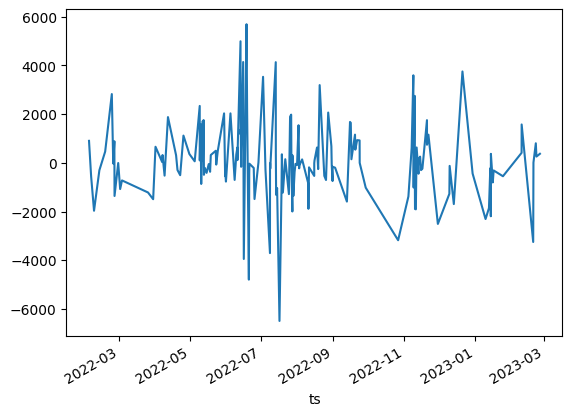

In [65]:
# plot reserve0 delta
cpmm_amm_baulking_df['reserve0_delta'].plot()

In [66]:
# get largest uni_swaps_df buy orders where swaps_tokenIn_id is WETH
uni_swaps_df[uni_swaps_df['swaps_tokenIn_id'] == 'WETH'].nlargest(10, 'swaps_amountIn_converted')

,trades_timestamp,swaps_tokenIn_id,swaps_tokenOut_id,swaps_amountIn_converted,swaps_amountOut_converted
12365,1669255727,WETH,USDC,8056.128947,9.941096e+06
30418,1670943647,WETH,USDC,5681.678604,7.656057e+06
17760,1673630771,WETH,USDC,5236.000000,7.396822e+06
26392,1675933067,WETH,USDC,4679.968892,7.602403e+06
28618,1658405944,WETH,USDC,2699.994991,4.010825e+06
15634,1667676575,WETH,USDC,2630.377813,4.278786e+06
28344,1670117639,WETH,USDC,2506.332137,3.177033e+06
6735,1667676671,WETH,USDC,2463.983489,4.004776e+06
7108,1661683811,WETH,USDC,2307.684933,3.418145e+06
33050,1676153039,WETH,USDC,2250.363309,3.457835e+06


In [67]:
cpmm_delta = (cpmm_amm_baulking_df["tvl"].shift(1) - cpmm_amm_baulking_df["tvl"]).rolling(10).mean()
oraclepool_delta = (oracle_pool_df["tvl"].shift(1) - oracle_pool_df["tvl"]).rolling(10).mean()

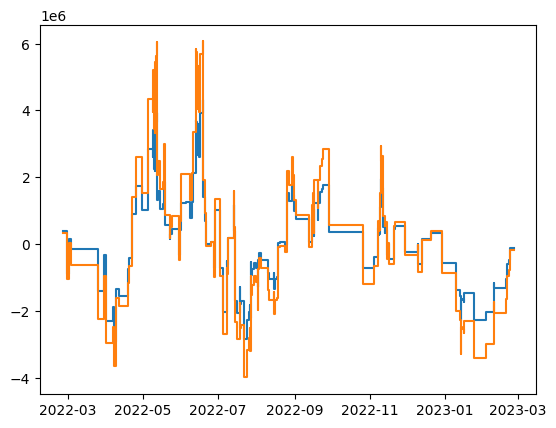

In [68]:
fig, ax = plt.subplots()
ax.step(cpmm_delta.index, cpmm_delta)
ax.step(oraclepool_delta.index, oraclepool_delta)

Correlation: 0.9975070387549166


<AxesSubplot:xlabel='ts'>

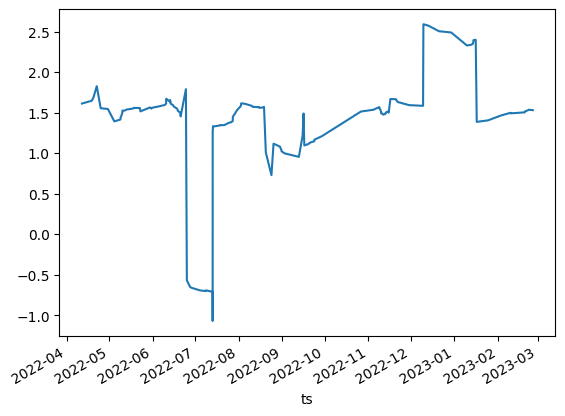

In [69]:
print(f"Correlation: {oraclepool_delta.corr(cpmm_delta)}")
beta = oraclepool_delta/cpmm_delta
beta.rolling(10).mean().plot()

In [70]:
def reserve_balance(df) -> pd.Series:
    return df["reserve0"] * df["prices_price"] / df["reserve1"]

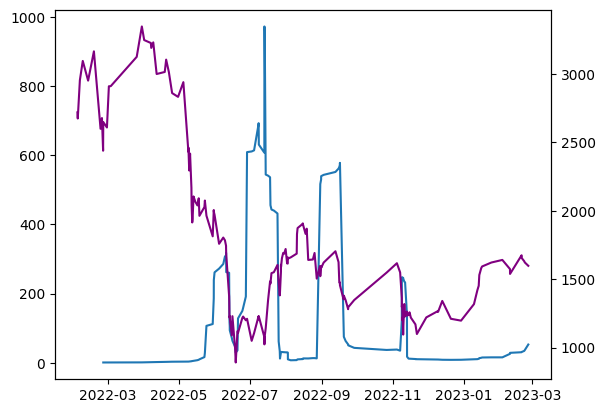

In [71]:
fig, ax = plt.subplots()
oraclepool_balance = reserve_balance(oracle_pool_df).rolling(10).mean()
ax.plot(oraclepool_balance.index, oraclepool_balance)
axr = ax.twinx()
axr.plot(oracle_pool_df["prices_price"], color="purple")